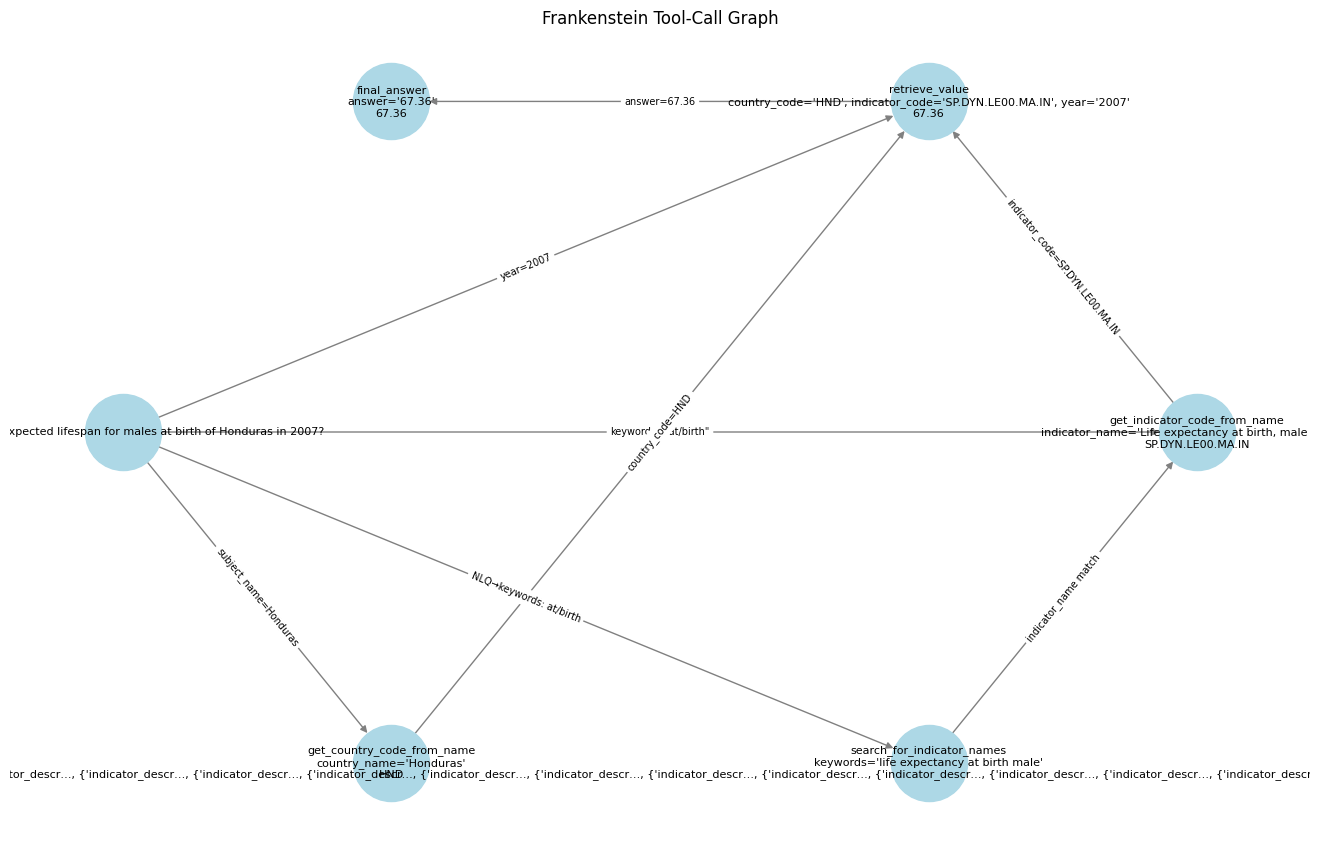

In [1]:
import logging
import os
import sys

import networkx as nx
import pandas as pd

# In Jupyter, __file__ is not defined, so use the current working directory
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from frankenstein.graph import FrankensteinGraph

# Suppress all logging from FrankensteinGraph and its dependencies
logging.getLogger().setLevel(logging.ERROR)

df = pd.read_json('../eval/runs/Qwen3-32B_answerable-full_all-tools_0-shot.jsonl', orient='records', lines=True)
df = df[df['answer_format'] == 'float']

G = FrankensteinGraph(df.iloc[40])
# G.draw_pretty()
G.draw('shell')

In [ ]:
import plotly.graph_objects as go

# Suppose G is your networkx.DiGraph with attributes
pos = nx.spring_layout(G)

edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=1), hoverinfo='none', mode='lines')

node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

    # Format hover text from metadata (e.g., function and result)
    attrs = G.nodes[node]
    text = f'{node}<br>func: {attrs.get("function")}<br>result: {str(attrs.get("result"))[:30]}'
    node_text.append(text)

node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers', hoverinfo='text', text=node_text, marker=dict(size=20, line=dict(width=2))
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(showlegend=False)
fig.show()


In [3]:
for node_id, attrs in G.nodes(data=True):
    print(f'Node ID: {node_id}')
    print(f'  Label: {attrs.get("label")}')
    print(f'  Arguments: {attrs.get("args")}')
    print(f'  Result: {attrs.get("result")}')


Node ID: question_root
  Label: What was the expected lifespan for males at birth of Honduras in 2007?
  Arguments: None
  Result: None
Node ID: chatcmpl-tool-7789b8b6dd274b249be13aa04891fee1
  Label: get_country_code_from_name
  Arguments: {'country_name': 'Honduras'}
  Result: HND
Node ID: chatcmpl-tool-d2d289bc52ec4f929d95e345d94c9e26
  Label: search_for_indicator_names
  Arguments: {'keywords': 'life expectancy at birth male'}
  Result: [{'indicator_description': 'Children out of school are the number of primary-school-age children not enrolled in primary or secondary school.', 'indicator_name': 'Children out of school, primary, male'}, {'indicator_description': 'The average time men spend on household provision of services for own consumption.  Data are expressed as a proportion of time in a day. Domestic and care work includes food preparation, dishwashing, cleaning and upkeep of a dwelling, laundry, ironing, gardening, caring for pets, shopping, installation, servicing and repai

In [4]:
def nodes_not_on_path(
    graph: FrankensteinGraph,
) -> list:
    """Return a list of nodes that are not on any path from the start node to the end node."""
    nodes = graph.nodes(data=True)

    end_node = next(n for n, attrs in nodes if attrs.get('label') == 'final_answer')

    unused_nodes = []
    for node_id, attrs in nodes:
        if not nx.has_path(graph, node_id, end_node):
            unused_nodes.append(node_id)

    return unused_nodes


# Example usage
unused_nodes = nodes_not_on_path(G)
for node_id in unused_nodes:
    print(f'Unused Node ID: {node_id}')
    attrs = G.nodes[node_id]
    print(f'  Label: {attrs.get("label")}')
    print(f'  Arguments: {attrs.get("args")}')
    print(f'  Result: {attrs.get("result")}')